In [2]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

In [10]:
base_data = np.load('../data/training_data/training_data_1month.npy', allow_pickle=True)[0][:,:,[0,3]]
vae_data = np.load('../data/vae_synthetic_data/th_v_air_rescaled_samples.npy', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data/vae_synthetic_data/el_v_sky_rescaled_samples.npy'

In [4]:
print(base_data.shape, vae_data.shape)

(108, 730, 2) (1000, 730, 2)


<h3> Plots </h3>

In [8]:
def plot_box(real_data, fake_data):
    sns.set(style="whitegrid")
    
    real_feature1, real_feature2 = real_data[:,:,0].flatten(), real_data[:,:,1].flatten()
    fake_feature1, fake_feature2 = fake_data[:,:,0].flatten(), fake_data[:,:,1].flatten()

    features = ['G.air.T', 'G.E_th_I']
    for index, feature in enumerate(features):
        data = {
            'Value': np.concatenate([real_data[:, :, index].flatten(), fake_data[:, :, index].flatten()]),
            'Type': ['Ground Truth'] * len(real_data[:, :, index].flatten()) + ['Synthetic (VAE)'] * len(fake_data[:, :, index].flatten()),
            'Feature': [feature] * (len(real_data[:, :, index].flatten()) + len(fake_data[:, :, index].flatten()))
        }

        # Plotting
        plt.figure(figsize=(8, 8))
        sns.boxplot(x='Feature', y='Value', hue='Type', data=pd.DataFrame(data), palette="Set2")
        plt.title(f'Boxplot Comparison of Ground Truth and Synthetic Data for {feature}')
        plt.xlabel('')
        plt.savefig(f'../imgs/vae_data/VAE_{feature}_boxplots.png')

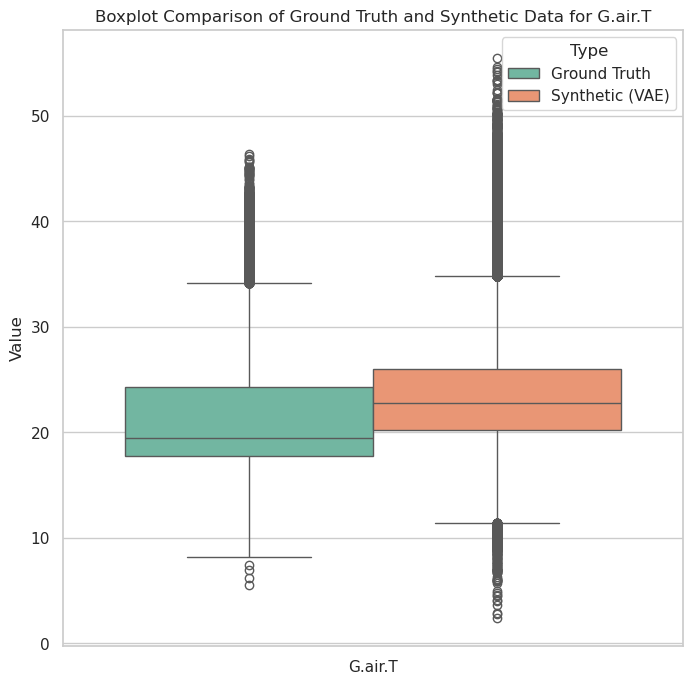

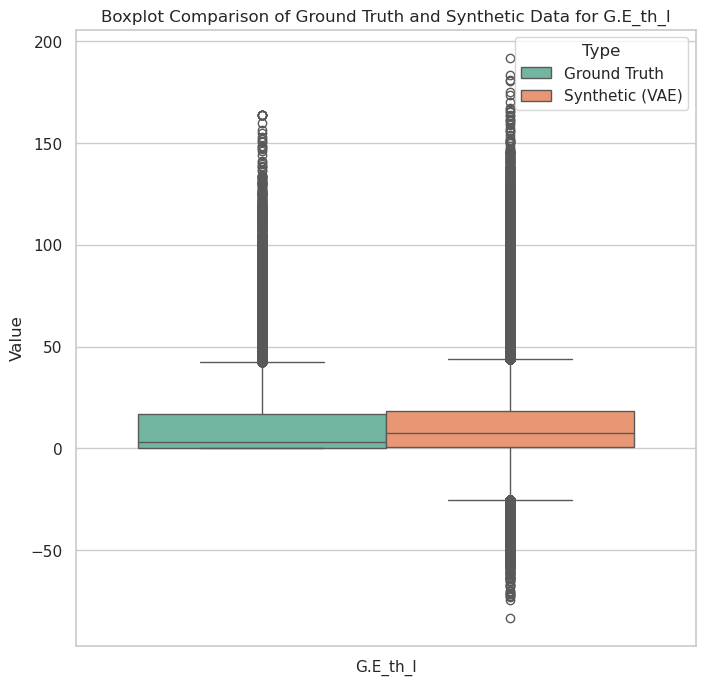

In [9]:
plot_box(base_data, vae_data)

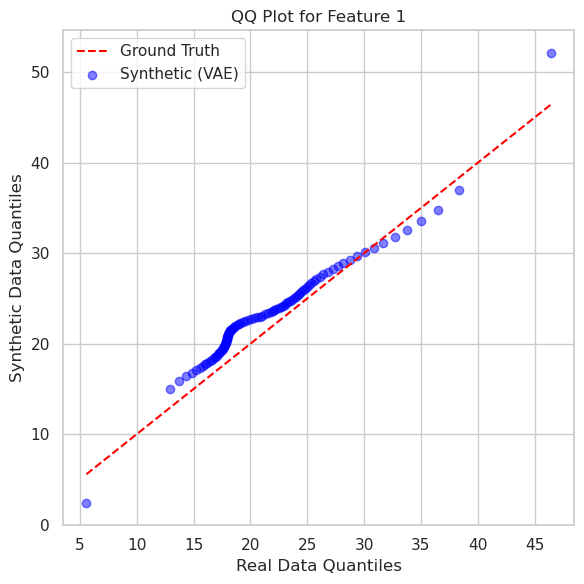

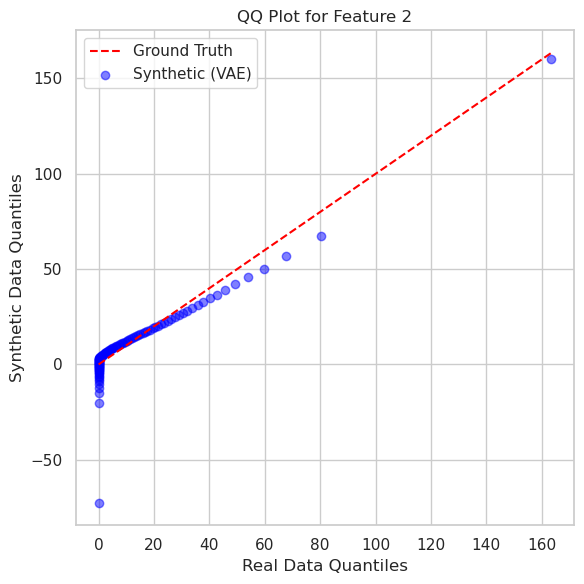

In [11]:
from scipy import stats

def plot_qq(real_data, synthetic_data, feature_index=0):
    sns.set(style="whitegrid")
    real_data_flattened = real_data[:,:,feature_index].flatten()
    synthetic_data_flattened = synthetic_data[:,:,feature_index].flatten()

    real_df = pd.DataFrame(real_data_flattened, columns=['Real Data'])
    synthetic_df = pd.DataFrame(synthetic_data_flattened, columns=['Synthetic Data'])
    
    synthetic_df = synthetic_df.iloc[:len(real_df)]

    quantiles = np.linspace(0,1,100)

    real_quantiles = np.quantile(real_df, quantiles)
    synthetic_quantiles = np.quantile(synthetic_df, quantiles)

    plt.figure(figsize=(6, 6))
    plt.plot(real_quantiles, real_quantiles, linestyle='--', color='red', label='Ground Truth')
    plt.scatter(real_quantiles, synthetic_quantiles, color='blue', alpha=0.5, label='Synthetic (VAE)')
    plt.xlabel('Real Data Quantiles')
    plt.ylabel('Synthetic Data Quantiles')
    plt.title(f'QQ Plot for Feature {feature_index + 1}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_qq(base_data, vae_data, 0)
plot_qq(base_data, vae_data, 1)

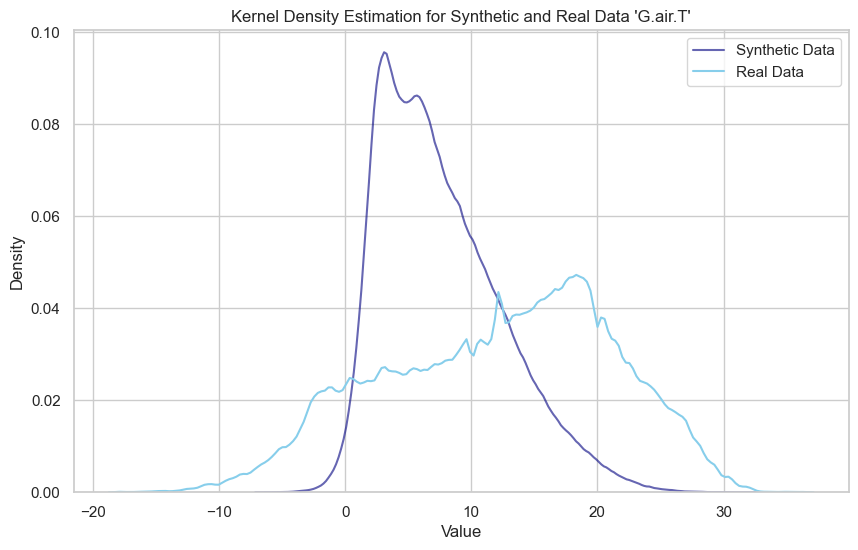

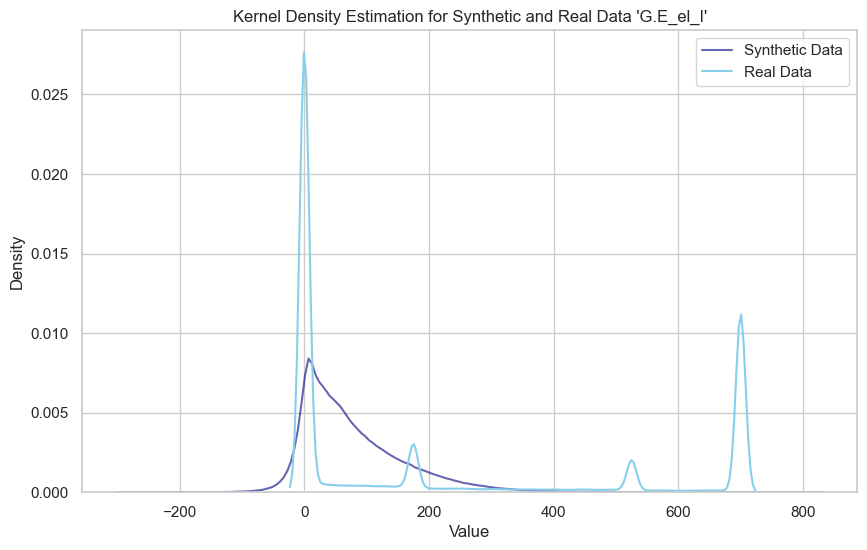

In [58]:
def plot_kde(synthetic_data, real_data, feature_index=0):
    sns.set(style="whitegrid")
    
    features = ['G.air.T', 'G.E_el_I']
    
    synthetic_feature_values = synthetic_data[:, :, feature_index].flatten()
    real_feature_values = real_data[:, :, feature_index].flatten()

    plt.figure(figsize=(10, 6))
    sns.kdeplot(synthetic_feature_values, label="Synthetic Data", bw_adjust=0.5, color="navy", alpha=0.6)
    sns.kdeplot(real_feature_values, label="Real Data", bw_adjust=0.5, color="skyblue")

    plt.title(f"Kernel Density Estimation for Synthetic and Real Data '{features[feature_index]}'")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_kde(vae_data, base_data, feature_index=0) 
plot_kde(vae_data, base_data, feature_index=1)

<h3> Statistical measures </h3>

In [39]:
base_data_flat, vae_data_flat = base_data.reshape(-1,2), vae_data.reshape(-1,2)

print(pd.DataFrame(base_data_flat).describe())
print(pd.DataFrame(vae_data_flat).describe())

                  0             1
count  2.376150e+06  2.376150e+06
mean   2.142786e+01  1.168470e+01
std    5.388154e+00  1.804095e+01
min    5.580089e+00 -2.651068e-07
25%    1.779077e+01  0.000000e+00
50%    1.946279e+01  2.985785e+00
75%    2.433023e+01  1.708645e+01
max    4.641036e+01  1.634586e+02
                  0             1
count  3.650000e+06  3.650000e+06
mean   2.091036e+01  8.709294e+00
std    3.791579e+00  1.094064e+01
min    7.773609e+00 -1.069125e+02
25%    1.819198e+01  1.183350e+00
50%    1.984705e+01  5.465488e+00
75%    2.267179e+01  1.263401e+01
max    4.763506e+01  1.609924e+02


<h3> Loss curves </h3>

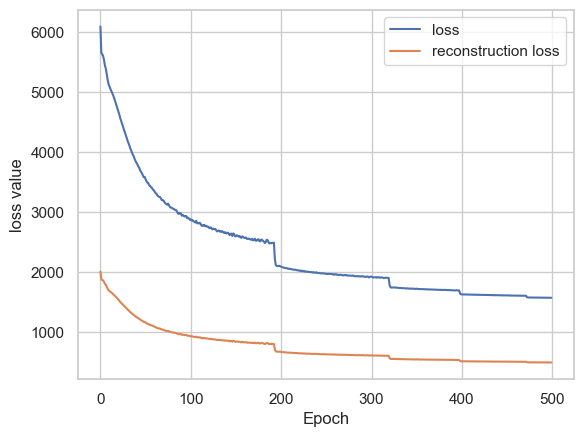

In [67]:
loss = pd.read_csv('../data/th_v_air_loss.csv')
plt.plot(loss['loss'], label='loss')
plt.plot(loss['reconstruction_loss'], label='reconstruction loss')
plt.xlabel('Epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()

In [26]:
import scipy.stats as stats

def plot_qq(real_data, synthetic_data):
    real_data = real_data.iloc[:len(synthetic_data)]

    quantiles = np.linspace(0,1,100)

    num_features = real_data.shape[1]
    fig, axs = plt.subplots(1, num_features, figsize=(5*num_features, 5), squeeze=False)

    for i in range(num_features):
        real_quantiles = np.quantile(real_data.iloc[:, i], quantiles)
        synthetic_quantiles = np.quantile(synthetic_data.iloc[:, i], quantiles)

        ax = axs[0,i]
        ax.plot(real_quantiles, real_quantiles, linestyle='--', color='red', label='Real Data')
        ax.scatter(real_quantiles, synthetic_quantiles, color='blue', alpha=0.5, label='Synthetic Data')

        ax.set_xlabel('Real Data Quantiles')
        ax.set_ylabel('Synthetic Data Quantiles')
        ax.title.set_text(f'{i+1}')

    plt.tight_layout()
    plt.show()

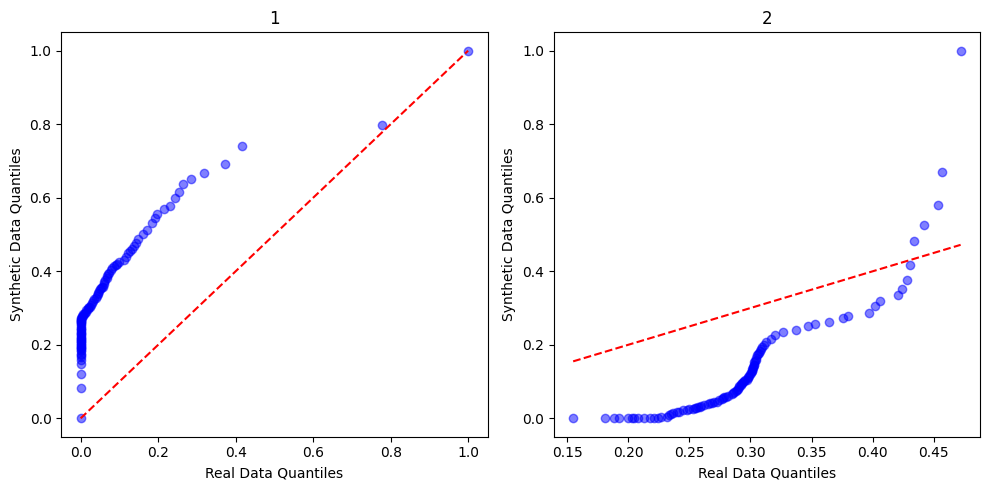

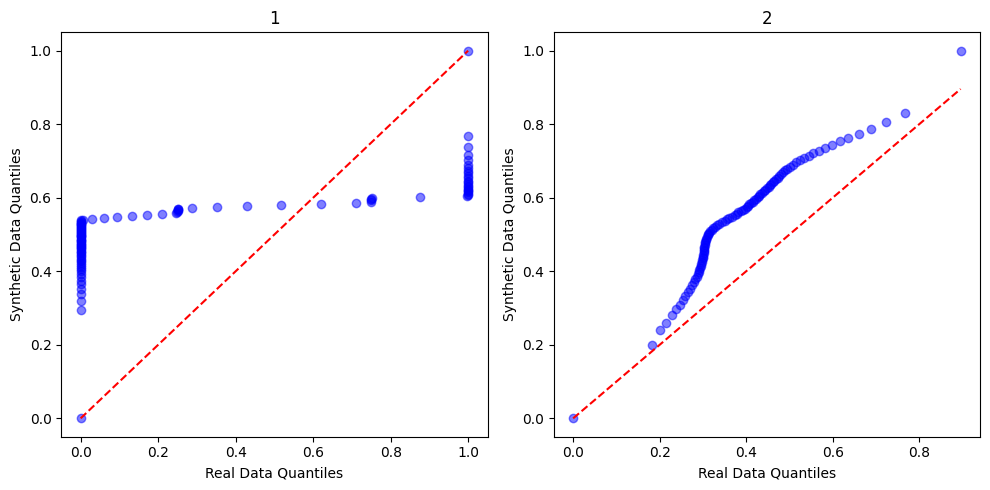

In [27]:
plot_qq(base_data[['G.E_th_I', 'G.air.T']].copy(), new_vae_scaled.copy())
plot_qq(base_data[['G.E_el_I', 'G.air.T']].copy(), new_gan_scaled.copy())

In [10]:
def plot_kde(synthetic_data, real_data):
    sns.set(style="whitegrid")

    plt.figure(figsize=(10,6))
    sns.kdeplot(synthetic_data['G.air.T'], label="Synthetic Data", bw_adjust=0.5, color="navy", alpha=0.6)
    sns.kdeplot(real_data['G.air.T'], label="Real Data", bw_adjust=0.5, color="skyblue")

    plt.title("Kernal Density Estimation for Synthetic and Real Data 'G.air.T'")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    sns.kdeplot(synthetic_data['G.E_el_I'], label="Synthetic Data", bw_adjust=0.5, color="navy", alpha=0.6)
    sns.kdeplot(real_data['G.E_el_I'], label="Real Data", bw_adjust=0.5, color="skyblue")

    plt.title("Kernal Density Estimation for Synthetic and Real Data 'G.E_el_I'")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

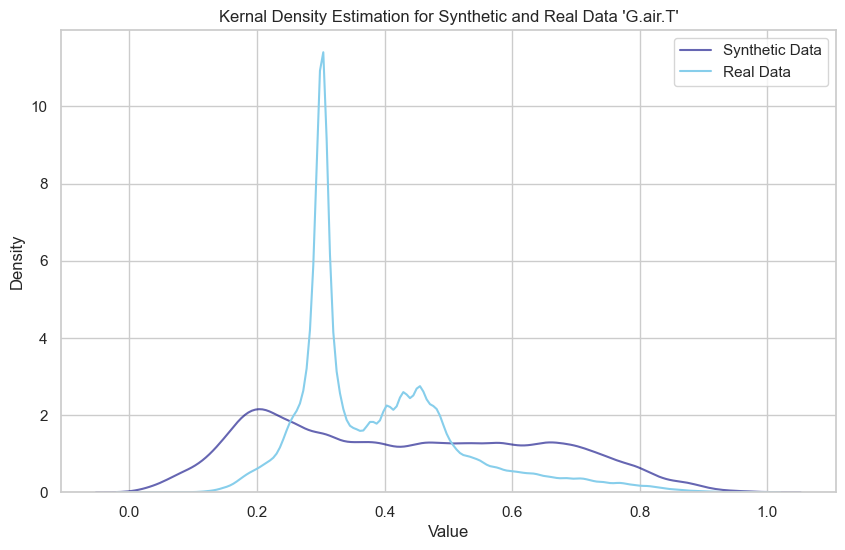

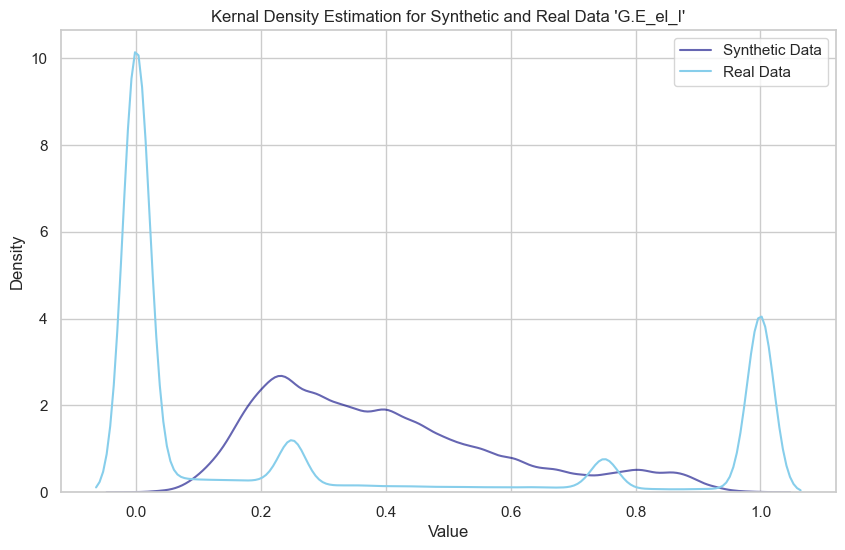

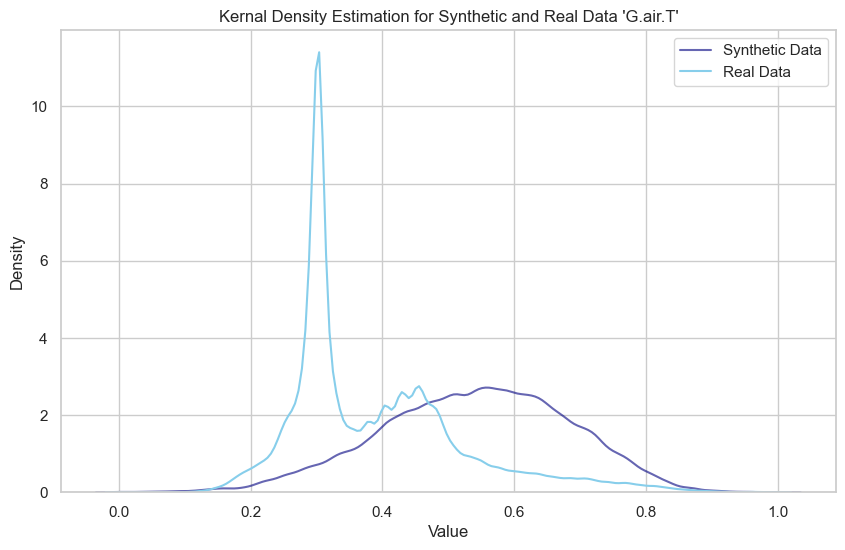

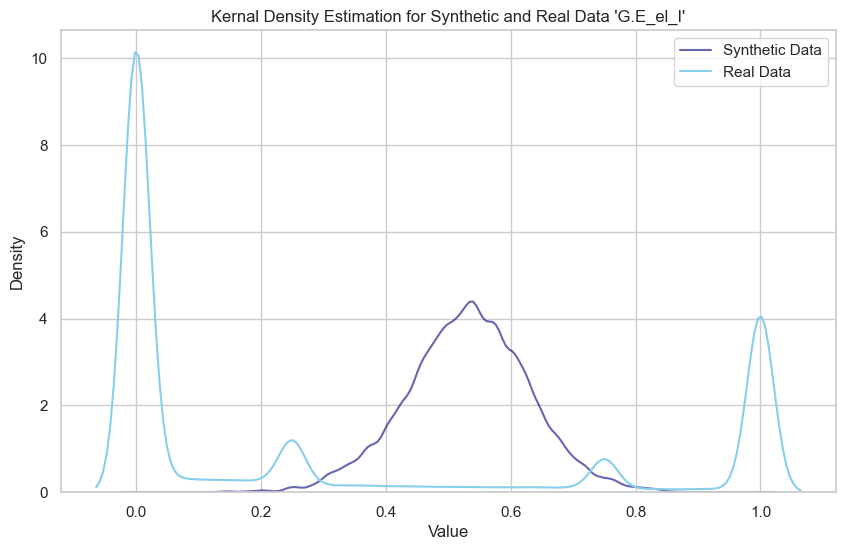

In [11]:
plot_kde(new_vae_scaled.copy(), base_data[['G.E_el_I', 'G.air.T']].copy())
plot_kde(new_gan_scaled.copy(), base_data[['G.E_el_I', 'G.air.T']].copy())

In [12]:
base_data['G.air.T'], new_vae_scaled['G.air.T']
new_vae_scaled.index = base_data[:8759*3600].index
new_gan_scaled.index = base_data[:8759*3600].index

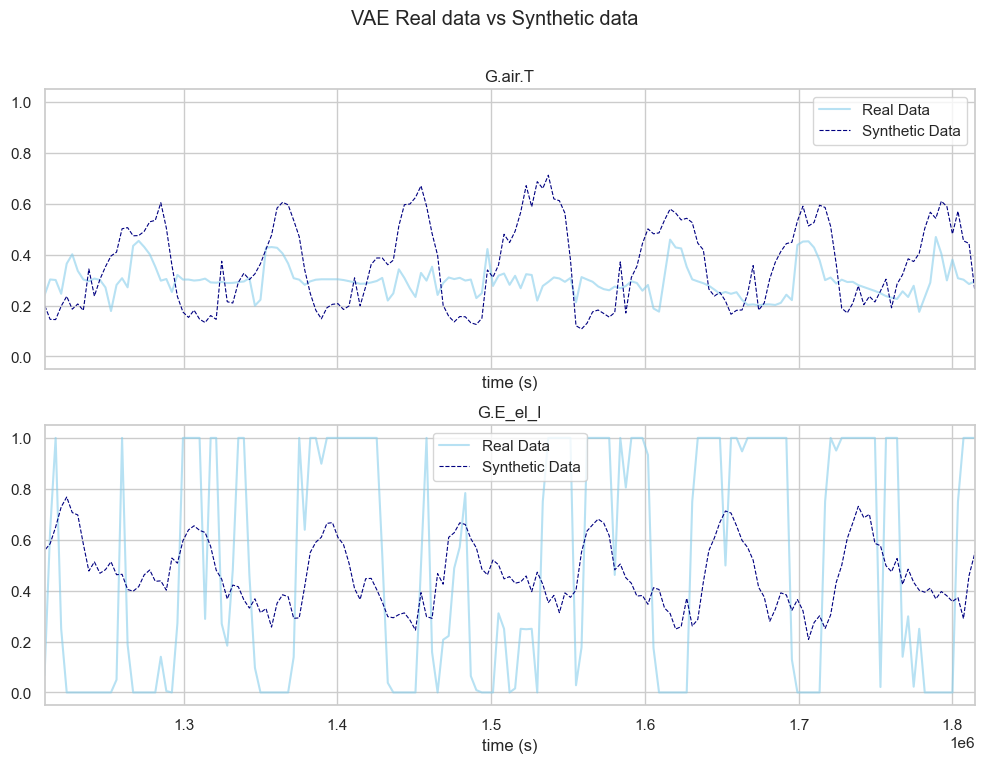

In [62]:
week_secs = 24*7*3600
start_week, end_week = 2, 3

vae_offset, gan_offset = 10, 0
x_base = np.arange(len(base_data['G.air.T']))
x_vae, x_gan = np.arange(vae_offset, len(new_vae_scaled['G.air.T']) + vae_offset), \
               np.arange(gan_offset, len(new_gan_scaled['G.air.T']) + gan_offset)

fig, ax = plt.subplots(2, figsize=(12,8), sharex=True)
fig.suptitle('VAE Real data vs Synthetic data')

ax[0].plot(x_base*3600, base_data['G.air.T'], color='skyblue', alpha=0.6, label='Real Data')
ax[0].plot(x_vae*3600, new_vae_scaled['G.air.T'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[0].set_xlim(week_secs*start_week, week_secs*end_week)
ax[0].set_title('G.air.T')
ax[0].legend()
ax[0].set_xlabel('time (s)')

ax[1].plot(x_base*3600, base_data['G.E_el_I'], color='skyblue', alpha=0.6, label='Real Data')
ax[1].plot(x_vae*3600, new_vae_scaled['G.E_el_I'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[1].set_xlim(week_secs*start_week, week_secs*end_week)
ax[1].set_title('G.E_el_I')
ax[1].legend()
ax[1].set_xlabel('time (s)')

plt.savefig('../images/real_vs_synth_vae_1.png')

[  10   11   12 ... 8767 8768 8769] [   0    1    2 ... 8757 8758 8759]


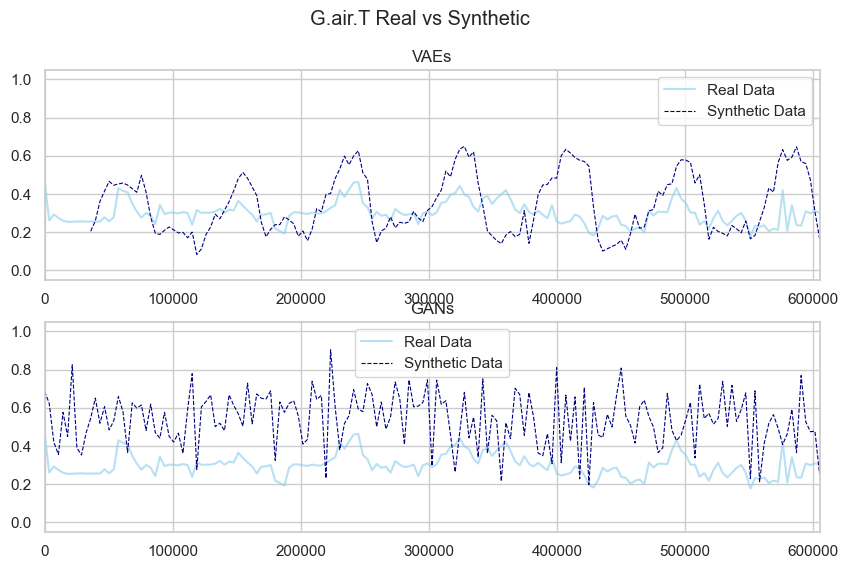

In [13]:
week_secs = 24*7*3600
start_week, end_week = 0, 1

vae_offset, gan_offset = 10, 0
x_base = np.arange(len(base_data['G.air.T']))
x_vae, x_gan = np.arange(vae_offset, len(new_vae_scaled['G.air.T']) + vae_offset), \
               np.arange(gan_offset, len(new_gan_scaled['G.air.T']) + gan_offset)

print(x_vae, x_gan)

fig, ax = plt.subplots(2, figsize=(10,6))
ax[0].plot(x_base*3600, base_data['G.air.T'], color='skyblue', alpha=0.6, label='Real Data')
ax[0].plot(x_vae*3600, new_vae_scaled['G.air.T'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[0].set_xlim(week_secs*start_week, week_secs*end_week)
ax[0].set_title('VAEs')
ax[0].legend()

ax[1].plot(x_base*3600, base_data['G.air.T'], color='skyblue', alpha=0.6, label='Real Data')
ax[1].plot(x_gan*3600, new_gan_scaled['G.air.T'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[1].set_xlim(week_secs*start_week, week_secs*end_week)
ax[1].set_title('GANs')
ax[1].legend()

fig.suptitle('G.air.T Real vs Synthetic')
plt.show()

[  10   11   12 ... 8767 8768 8769] [   0    1    2 ... 8757 8758 8759]


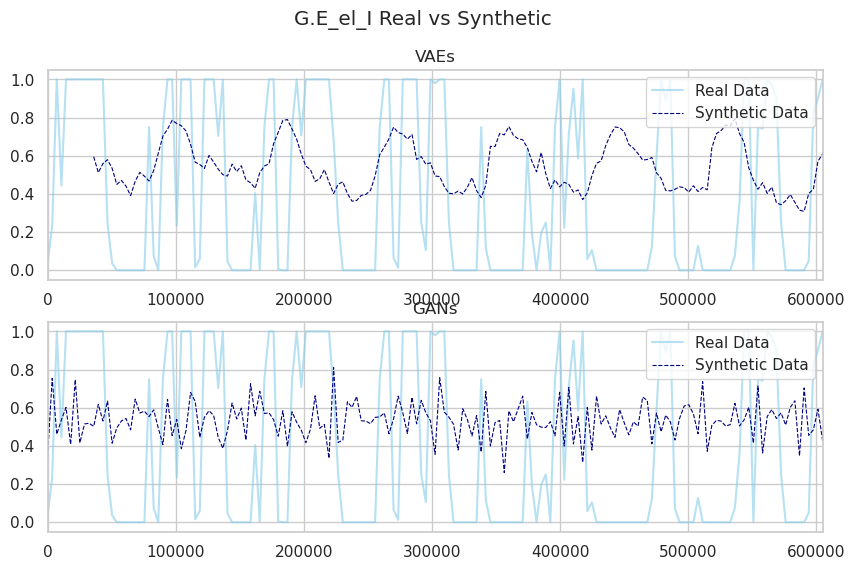

In [20]:
week_secs = 24*7*3600
start_week, end_week = 0, 1

vae_offset, gan_offset = 10, 0
x_base = np.arange(len(base_data['G.E_el_I']))
x_vae, x_gan = np.arange(vae_offset, len(new_vae_scaled['G.E_el_I']) + vae_offset), \
               np.arange(gan_offset, len(new_gan_scaled['G.E_el_I']) + gan_offset)

print(x_vae, x_gan)

fig, ax = plt.subplots(2, figsize=(10,6))
ax[0].plot(x_base*3600, base_data['G.E_el_I'], color='skyblue', alpha=0.6, label='Real Data')
ax[0].plot(x_vae*3600, new_vae_scaled['G.E_el_I'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[0].set_xlim(week_secs*start_week, week_secs*end_week)
ax[0].set_title('VAEs')
ax[0].legend()

ax[1].plot(x_base*3600, base_data['G.E_el_I'], color='skyblue', alpha=0.6, label='Real Data')
ax[1].plot(x_gan*3600, new_gan_scaled['G.E_el_I'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[1].set_xlim(week_secs*start_week, week_secs*end_week)
ax[1].set_title('GANs')
ax[1].legend()

fig.suptitle('G.E_el_I Real vs Synthetic')
plt.show()

<h2>Creating shuffled sets and testing strategies </h2>

In [147]:
print(base_data.shape)

print(new_vae_data.shape, new_gan_data.shape)

(87601, 9)
(100, 8760, 2) (1000, 4380, 2)


<h4>Synthetic Data at the front</h4>

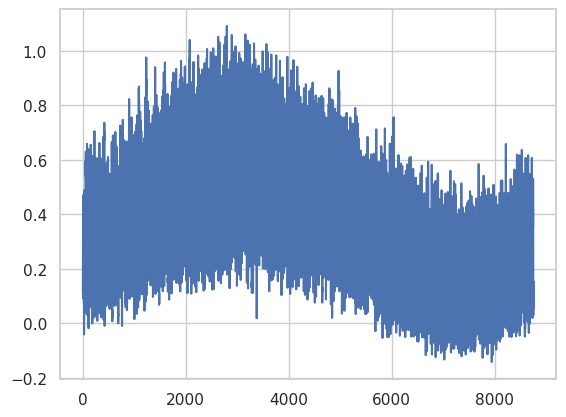

In [211]:
plt.plot(new_vae_data[0,:,1])

In [212]:
insertion_vae_data = pd.DataFrame(scaler.fit_transform(new_vae_data[0]), columns=['G.E_el_I', 'G.air.T'])
insertion_gan_data = pd.DataFrame(scaler.fit_transform(np.concatenate([new_gan_data[0],new_gan_data[1]])), columns=['G.E_el_I', 'G.air.T'])

print(len(insertion_vae_data), len(insertion_gan_data))

updated_vae_df1 = pd.concat([insertion_vae_data, base_data[['G.E_el_I', 'G.air.T']]], ignore_index=True, axis=0)
updated_gan_df1 = pd.concat([insertion_gan_data, base_data[['G.E_el_I', 'G.air.T']]], ignore_index=True, axis=0)
print(updated_vae_df1, updated_gan_df1)

8760 8760
       G.E_el_I   G.air.T
0      0.594565  0.204640
1      0.511724  0.258614
2      0.558451  0.360380
3      0.579148  0.414607
4      0.533677  0.465477
...         ...       ...
96356  0.999982  0.295766
96357  0.999982  0.296697
96358  0.999982  0.295191
96359  0.999982  0.295438
96360  0.999982  0.293799

[96361 rows x 2 columns]         G.air.T  G.E_el_I
0      0.316442  0.376166
1      0.501694  0.301253
2      0.119063  0.807322
3      0.008298  1.000000
4      0.000000  0.969740
...         ...       ...
96356  0.295766  0.999982
96357  0.296697  0.999982
96358  0.295191  0.999982
96359  0.295438  0.999982
96360  0.293799  0.999982

[96361 rows x 2 columns]


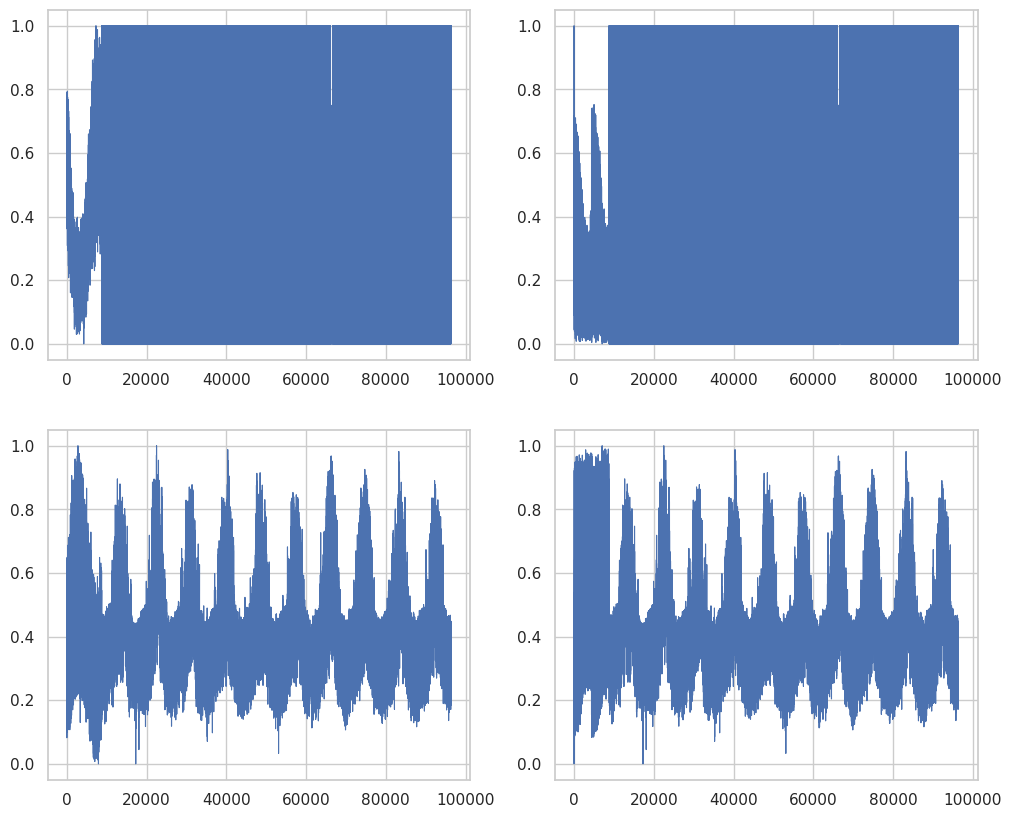

In [213]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
for i in range(2):
    ax[i, 0].plot(updated_vae_df1['G.air.T' if i == 1 else 'G.E_el_I'], linewidth = 0.8)
    ax[i, 1].plot(updated_gan_df1['G.air.T' if i == 1 else 'G.E_el_I'], linewidth = 0.8)

In [221]:
updated_vae_df1.to_csv('../data/testing_data_vae_1.csv', index=False)
updated_gan_df1.to_csv('../data/testing_data_gan_1.csv', index=False)

<h4>Synthetic Data throughout</h4>

In [214]:
real_data = base_data[['G.E_el_I', 'G.air.T']].copy()

insertion_vae_data, insertion_gan_data = [], []
for i in range(5):
    insertion_vae_data.append(pd.DataFrame(scaler.fit_transform(new_vae_data[i]), columns=['G.E_el_I', 'G.air.T']))
    insertion_gan_data.append(pd.DataFrame(scaler.fit_transform(np.concatenate([new_gan_data[i],new_gan_data[i+1]])), columns=['G.E_el_I','G.air.T']))

num_segments = 5
segment_len = len(real_data) // num_segments

updated_vae_df2, updated_gan_df2 = [], []

for i in range(num_segments):
    start_idx = i * segment_len * 3600
    end_idx = (i + 1) * segment_len * 3600 if i < num_segments - 1 else len(real_data) * 3600
    print(start_idx, end_idx)
    
    current_seg = real_data[start_idx:end_idx]
    print(current_seg.shape)
    
    combined_seg_vae = np.concatenate((insertion_vae_data[i], current_seg))
    combined_seg_gan = np.concatenate((insertion_gan_data[i], current_seg))
    
    updated_vae_df2.append(combined_seg_vae)
    updated_gan_df2.append(combined_seg_gan)
    
updated_vae_df2 = pd.DataFrame(np.concatenate(updated_vae_df2), columns=['G.E_el_I', 'G.air.T'])
updated_gan_df2 = pd.DataFrame(np.concatenate(updated_gan_df2), columns=['G.E_el_I', 'G.air.T'])

print(updated_vae_df2.shape, updated_gan_df2.shape)

0 63072000
(17521, 2)
63072000 126144000
(17521, 2)
126144000 189216000
(17521, 2)
189216000 252288000
(17521, 2)
252288000 315363600
(17521, 2)
(131405, 2) (131405, 2)


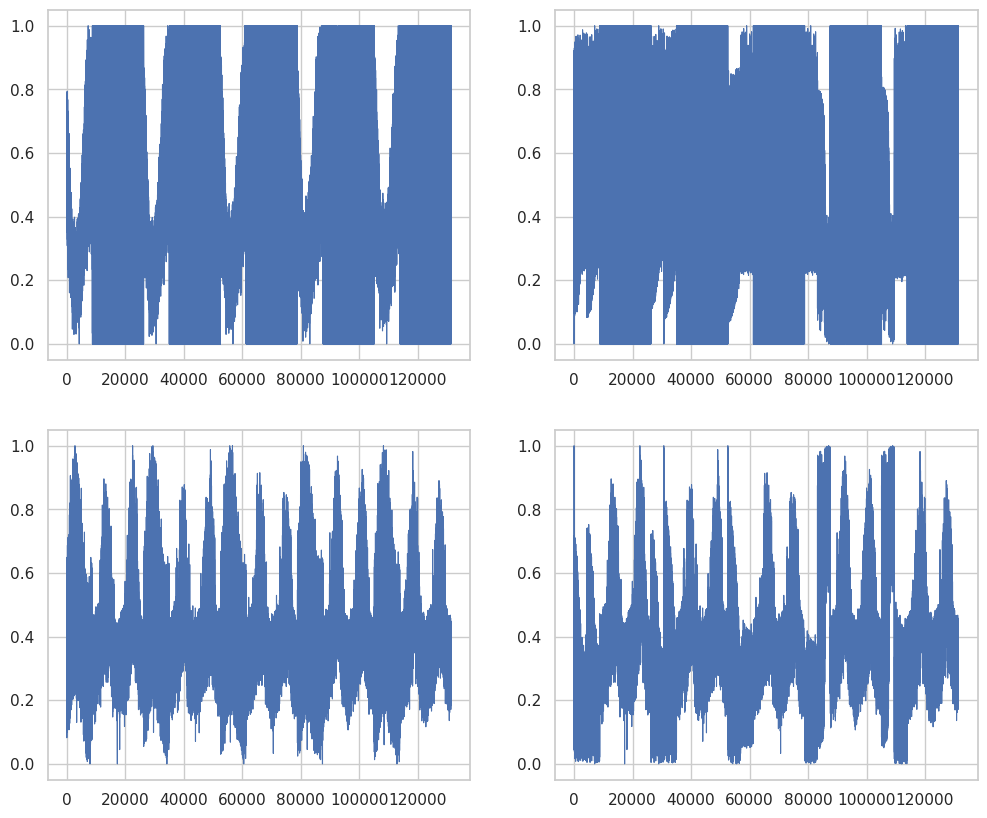

In [215]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
for i in range(2):
    ax[i, 0].plot(updated_vae_df2['G.air.T' if i == 1 else 'G.E_el_I'], linewidth = 0.8)
    ax[i, 1].plot(updated_gan_df2['G.air.T' if i == 1 else 'G.E_el_I'], linewidth = 0.8)

In [222]:
updated_vae_df2.to_csv('../data/testing_data_vae_2.csv', index=False)
updated_gan_df2.to_csv('../data/testing_data_gan_2.csv', index=False)

<h4>All Synthetic Data with real data run at the end</h4>